In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

<h4>1. Carga del conjunto de datos</h4>

In [3]:
df = pd.read_csv('datasets/transformed_bankdataset.csv')

<h4>2. Exploración inicial del conjunto de datos</h4>

In [5]:
# Ver las primeras filas del dataframe
print(df.head())

# Información general sobre el dataframe
print(df.info())

    age         job  marital  education default  balance housing loan  \
0  59.0      admin.  married  secondary      no     2343     yes   no   
1  56.0      admin.  married  secondary      no       45      no   no   
2  41.0  technician  married  secondary      no     1270     yes   no   
3  55.0    services  married  secondary      no     2476     yes   no   
4  54.0      admin.  married   tertiary      no      184      no   no   

   contact  day  ... campaign  pdays  previous  poutcome  deposit balance_log  \
0  unknown    5  ...        1     -1         0   unknown      yes    9.126089   
1  unknown    5  ...        1     -1         0   unknown      yes    8.838407   
2  unknown    5  ...        1     -1         0   unknown      yes    9.001962   
3  unknown    5  ...        1     -1         0   unknown      yes    9.140454   
4  unknown    5  ...        2     -1         0   unknown      yes    8.858369   

  duration_log  campaign_log  pdays_log  previous_log  
0     6.950815    

<h4>3. División del conjunto de datos</h4>

In [7]:
# Separar las características y la variable objetivo
df = df.drop(columns=['balance', 'duration', 'campaign', 'pdays', 'previous'])# Seleccionamos solo las columnas transformadas (eliminando outliers)

X = df.drop(columns='deposit')
y = df['deposit']

# Dividir el conjunto de datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Se utiliza una proporción de 70-30 para asegurar un conjunto de entrenamiento robusto y un conjunto de prueba que
# permita evaluar el rendimiento del modelo de manera efectiva. La división en estratos asegura que ambas partes
# tengan una representación similar de las clases en la variable objetivo.


<h4>4. Codificación de variables categóricas</h4>

In [9]:
# Codificación de variables categóricas utilizando one-hot encoding (cambiar los string por binarios)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Asegurar que ambas divisiones tengan las mismas columnas después de la codificación
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# One-hot encoding es adecuado aquí ya que transforma cada categoría en una nueva columna binaria,
# permitiendo que el modelo interprete cada categoría sin asumir un orden entre ellas.

<h4>5. Estandarización de variables numéricas</h4>

In [11]:
# Seleccionar las variables numéricas
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# La estandarización se utiliza para garantizar que todas las variables contribuyan de manera equitativa al modelo,
# especialmente para algoritmos que son sensibles a la escala de las variables, como KNN.

In [12]:
X_train.describe()

,age,day,balance_log,duration_log,campaign_log,pdays_log,previous_log
count,7.813000e+03,7.813000e+03,7.813000e+03,7.813000e+03,7.813000e+03,7.813000e+03,7.813000e+03
mean,2.150817e-16,3.455859e-17,4.539907e-15,1.691552e-16,-1.191362e-16,-2.864725e-17,3.865105e-17
std,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00
min,-1.947480e+00,-1.748463e+00,-3.305727e+01,-4.372030e+00,-8.091122e-01,-5.770501e-01,-4.995518e-01
25%,-7.675924e-01,-9.183904e-01,-5.711427e-01,-6.247222e-01,-8.091122e-01,-5.770501e-01,-4.995518e-01
50%,-1.776487e-01,3.026393e-02,-3.317009e-01,2.437213e-02,-5.819879e-02,-5.770501e-01,-4.995518e-01
75%,6.651281e-01,7.417546e-01,2.428714e-01,7.187716e-01,5.242549e-01,8.261148e-01,4.408155e-01
max,4.373346e+00,1.808991e+00,9.529503e+00,2.715739e+00,7.219336e+00,2.404192e+00,7.388611e+00


In [13]:
X_test.head()

,age,day,balance_log,duration_log,campaign_log,pdays_log,previous_log,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
4164,-0.430482,0.030264,-0.429174,-0.381485,-0.809112,-0.577050,-0.499552,False,False,False,...,False,False,False,False,False,False,True,False,False,True
2131,-0.683315,1.097500,-0.579148,0.925076,-0.058199,0.520079,2.988751,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7450,0.665128,-0.444063,0.279952,1.162492,-0.809112,-0.577050,-0.499552,True,False,False,...,False,True,False,False,False,False,False,False,False,True
4389,-0.851870,1.690409,0.065276,0.184235,-0.809112,1.399770,1.625538,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5903,-1.188981,-1.155554,-0.642035,-0.456507,-0.809112,-0.577050,-0.499552,False,False,False,...,False,False,False,False,False,False,False,False,False,True


<h4>6. Entrenar el modelo</h4>

In [15]:
# Crear el modelo Random Forest para clasificación
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [37]:
# Convertir las etiquetas de texto a valores binarios (0 y 1)
label_encoder = LabelEncoder()

# Asegurarse de que el LabelEncoder conoce todas las posibles etiquetas
label_encoder.fit(['no', 'yes'])  # Ajustar explícitamente las etiquetas posibles

# Transformar las etiquetas de entrenamiento y prueba
y_train_encoded = label_encoder.transform(y_train)  # Solo transform, ya que ya está ajustado
y_test_encoded = label_encoder.transform(y_test)


In [39]:
# Entrenar el modelo
model.fit(X_train, y_train_encoded)

RandomForestClassifier(random_state=42)

<h4>7. Predicciones</h4>

In [41]:
y_pred = model.predict(X_test)

<h4>8. Metricas de evaluación</h4>

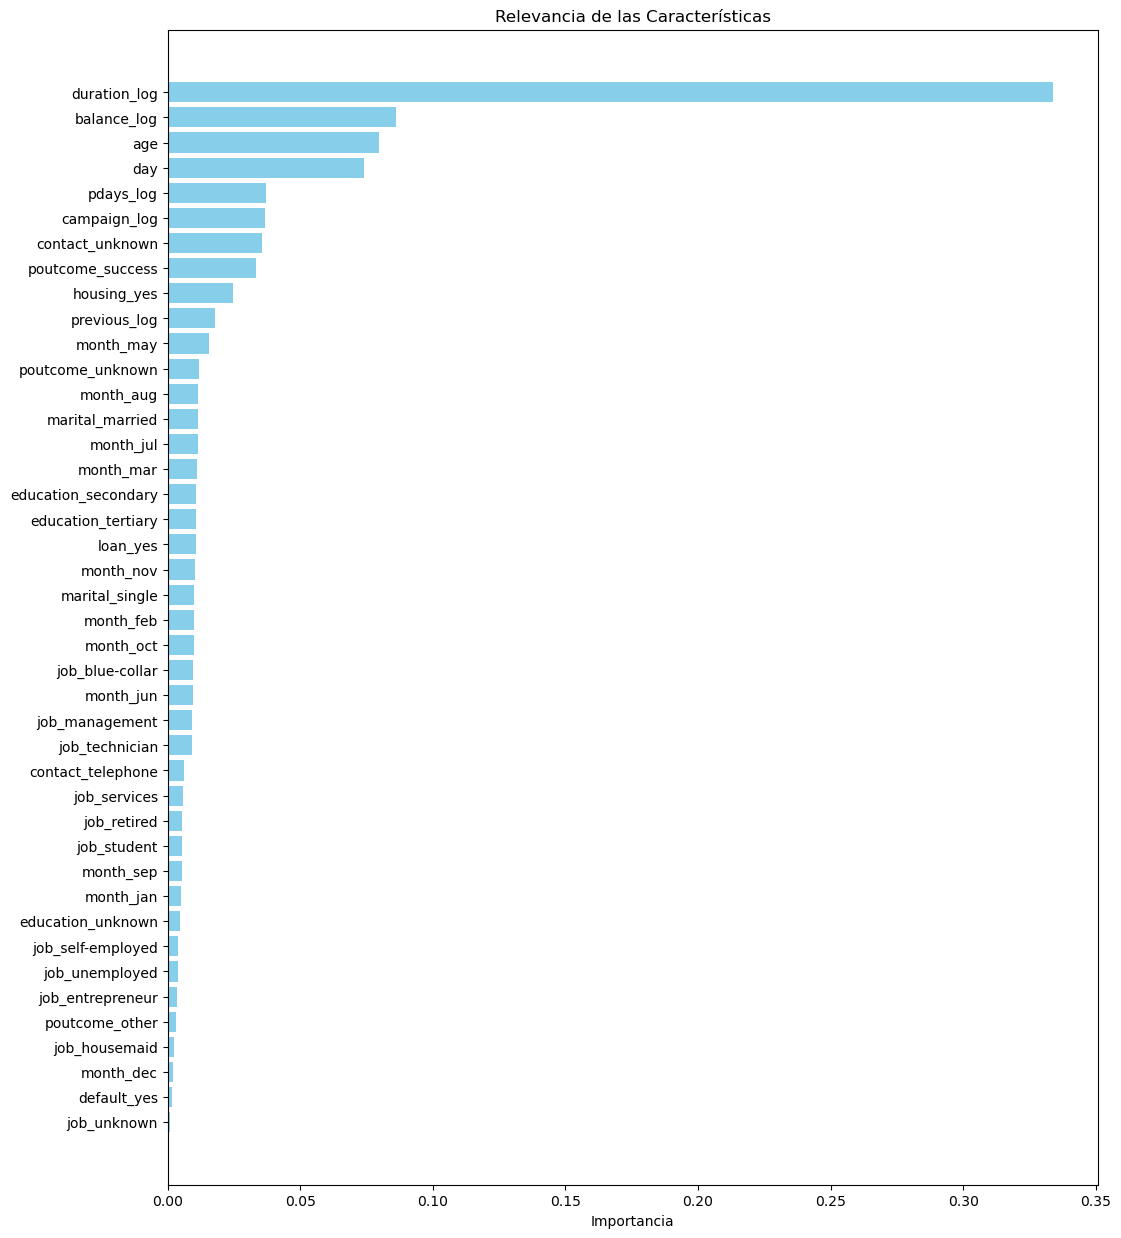

In [43]:
# Obtener la importancia de características
feature_importances = model.feature_importances_

# Crear un DataFrame con las importancias y nombres de las características
feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las importancias
plt.figure(figsize=(12, 15))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Relevancia de las Características')
plt.xlabel('Importancia')
plt.show()

Precisión (Accuracy): 0.8588
Recall (Sensibilidad): 0.8828
Precisión Positiva (Precision): 0.8300
AUC-ROC: 0.9211
F1-Score: 0.8556
Matriz de Confusión:
[[1475  287]
 [ 186 1401]]


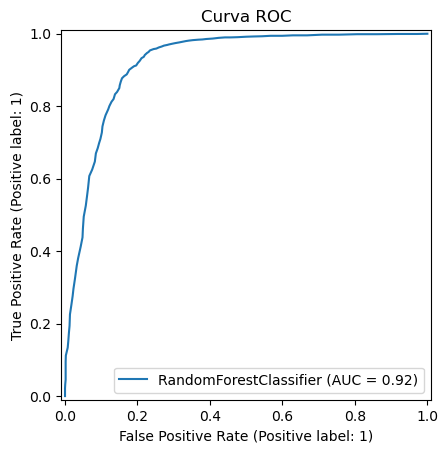

In [53]:
# Ajustar el codificador para las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(['no', 'yes'])

# Codificar las etiquetas de entrenamiento y prueba
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Generar las predicciones del modelo
y_pred = model.predict(X_test)

# Asegurar que las predicciones estén codificadas
if isinstance(y_pred[0], str):
    y_pred_encoded = label_encoder.transform(y_pred)
else:
    y_pred_encoded = y_pred

# Precisión (Accuracy)
accuracy = accuracy_score(y_test_encoded, y_pred_encoded) 
print(f"Precisión (Accuracy): {accuracy:.4f}")

# Recall (Sensibilidad)
recall = recall_score(y_test_encoded, y_pred_encoded)  
print(f"Recall (Sensibilidad): {recall:.4f}")

# Precisión Positiva (Precision)
precision = precision_score(y_test_encoded, y_pred_encoded)  
print(f"Precisión Positiva (Precision): {precision:.4f}")

# AUC-ROC
if hasattr(model, "predict_proba"): 
    roc_auc = roc_auc_score(y_test_encoded, model.predict_proba(X_test)[:, 1]) 
    print(f"AUC-ROC: {roc_auc:.4f}")

# F1-Score
f1 = f1_score(y_test_encoded, y_pred_encoded)
print(f'F1-Score: {f1:.4f}')

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)  
print(f"Matriz de Confusión:\n{conf_matrix}")

# Graficar la curva ROC
if hasattr(model, "predict_proba"):
    RocCurveDisplay.from_estimator(model, X_test, y_test_encoded)  
    plt.title('Curva ROC')
    plt.show()

<h4>8. Resumen del Análisis de los Resultados del Modelo </h4>

El modelo Random Forest para clasificación utilizado para predecir la fidelización de clientes ha mostrado un rendimiento notable, con métricas clave que demuestran su capacidad para identificar clientes potenciales y mejorar las campañas de fidelización.
<br><br>
<h5>Evaluación del Rendimiento del Modelo:</h5>

<h5>Precisión (Accuracy):</h5> 85.88%. El modelo ha clasificado bien un alto porcentaje de los clientes, lo que indica una buena capacidad general para predecir la fidelización.

<h5>Recall (Sensibilidad):</h5> 88.28%. El modelo identifica correctamente a la mayoría de los clientes realmente interesados en productos de fidelización, reduciendo el riesgo de perder clientes potenciales.

<h5>Precisión Positiva (Precision):</h5> Un 83.00% de los clientes clasificados como interesados realmente lo están, lo que minimiza los falsos positivos.

<h5>AUC-ROC:</h5> 0.9211. El modelo tiene una gran capacidad para distinguir entre los clientes que aceptarán el producto y los que no, lo que lo hace muy efectivo en la toma de decisiones.

<h5>F1-Score:</h5> 0.8556. Un buen equilibrio entre la precisión y el recall, que refleja una capacidad equilibrada para identificar clientes potenciales sin sobrecargas por falsos positivos.

<h5>Matriz de Confusión:</h5> La matriz de confusión muestra que el modelo clasifica correctamente a la mayoría de los clientes, con 1475 verdaderos negativos y 1401 verdaderos positivos, y un número bajo de falsos negativos (287) y falsos positivos (186).
<br><br><br>
<h5>Relación con los Objetivos del Negocio:</h5>

<h5>Tasa de Conversión y Retención:</h5> Las altas métricas de precisión y recall aseguran que las campañas de fidelización se dirijan a los clientes correctos, mejorando la tasa de conversión y reduciendo el churn.
<h5>Aumento del CLV y NPS:</h5> La identificación de clientes potenciales ayuda a aumentar el valor de vida del cliente (CLV) y a mejorar el Net Promoter Score (NPS), lo que refleja una mayor satisfacción y fidelización.
<br><br><br>


<h5>Impacto en el Problema de Negocio</h5>
<h5>Mejor Segmentación de Clientes:</h5> Las variables identificadas pueden ayudar a segmentar los clientes según su probabilidad de aceptación Por ejemplo:<br>
  - Priorizar clientes con interacciones largas (duration_log).
  - Enfocarse en aquellos con saldos más altos (balance_log).
<h5>Optimización de Recursos:</h5> La duración de las llamadas y el historial de campañas exitosas sugieren que las interacciones de calidad son más valiosas que la cantidad de intentos de contacto (previous_x). Las campañas pueden rediseñarse para enfocarse en la calidad.
<br><br><br>


<h5>Propuestas de Mejora</h5>
<h5>Diseño de Campañas Personalizadas:</h5>
Campañas basadas en las características de mayor importancia, como la duración de la llamada, historial de éxito (poutcome_success), y saldo bancario. Pero además, implementar estrategias específicas para clientes con bajo nivel de interacción pero alto saldo promedio, para maximiziar potenciales interacciones.

<h5>Seguimiento Basado en Datos:</h5>
Para clientes con altos valores en campaign_log (campaign_log alto puede sugerir fatiga en el clientes, por muchos contactos) y pdays_log (pdays_log alto podría indicar más recepción a ser contactado nuevamente, al no haber sido contactado en varios días) sería necesario ajustar el número de contactos, buscando un equilibrio, para maximizar fidelizaciones; principalmente si dichos clientes cuentan con altos sueldos o interacciones largas en su último contacto.

<h5>Análisis Temporal:</h5>
Usar patrones identificados en la variable day para determinar los mejores días para contactar a los clientes.

<h5>Entrenamiento al Personal:</h5>
Dado el impacto de duration_log, proporcionar formación al personal para realizar llamadas más efectivas que mantengan a los clientes interesados.


<br><br>
<h5>Nota:</h5>
Aunque en el análisis inicial la variable age parecía poco relevante, tras el entrenamiento del modelo adquirió una importancia significativa. Esto sugiere que la edad influye en la fidelización, posiblemente en combinación con otras variables. Se recomiendan las siguientes estrategias:

<h5>Segmentar campañas según grupos de edad:</h5> Crear ofertas o mensajes personalizados para cada rango.

<h5>Priorizar recursos en grupos de mayor fidelización:</h5> Focalizar esfuerzos en los segmentos de edad con mejor respuesta a campañas.

<h5>Explorar interacciones con otras variables:</h5> Analizar cómo la edad se relaciona con variables como balance u housing para diseñar estrategias más efectivas.